In [1]:
import pandas as pd
import plotly.express as px
import torch
from einops import rearrange
import torch
import tqdm

In [2]:
from importlib import reload
from mamba_lens import HookedMamba
model = HookedMamba.from_pretrained("state-spaces/mamba-370m", device='cuda')
torch.set_grad_enabled(False)

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


In [58]:
def get_pad_token(tokenizer):
    return model.tokenizer.encode(model.tokenizer.pad_token, add_special_tokens=False)[0]

# given data that is [N,V] and indicies that are [N,K] with each index being an index into the V space
# this does what you'd want, it indexes them
# idk, see the test
def index_into(data, indices):
    num_data, num_per_data = indices.size()
    # we want
    # [0,0,0,...,] num per data of these
    # [1,1,1,...,] num per data of these
    # ...
    # [num_data-1, num_data-1, ...]
    first_axis_index = torch.arange(num_data, dtype=torch.long).view(num_data, 1)*torch.ones([num_data, num_per_data], dtype=torch.long)
    # now we flatten it so it has an index for each term aligned with our indices
    first_axis_index = first_axis_index.flatten()

    second_axis_index = indices.flatten()
    # now we can just index, and then view back to our original shape
    return data[first_axis_index, second_axis_index].view(num_data, num_per_data)
    

def eval_debug(model, data, correct, incorrect, constrain_to_answers, **kwargs):
    for data_i in range(correct.size()[0]):
        input = model.tokenizer.decode(data[data_i])
        top_k = 2
        logits = model.forward(input, **kwargs)[0,-1]
        correct_answers = correct[data_i]
        incorrect_answers = incorrect[data_i]
        if constrain_to_answers:
            only_consider_answer_logits = torch.full(logits.size(), fill_value=-torch.inf, device=model.cfg.device)
            only_consider_answer_logits[correct_answers] = logits[correct_answers]
            only_consider_answer_logits[incorrect_answers] = logits[incorrect_answers]
            logits = only_consider_answer_logits
        prs = torch.nn.functional.softmax(logits, dim=0)
        top = torch.argsort(-logits)[:top_k]
        printed = False
        printed_prompt = False
        for i, tok in enumerate(top):
            if not i == 0 and tok in correct_answers:
                if not printed_prompt:
                    print("prompt", input)
                    printed_prompt = True
                print(f"  correct top {i} token {repr(model.tokenizer.decode([tok]))} logit {logits[tok]} prs {prs[tok]}")
                printed = True
                #print("correct")
                #print(f"token {model.tokenizer.decode([tok])} logit {logits[tok]} prs {prs[tok]}")
            elif i == 0 and not tok in correct_answers:
                if not printed_prompt:
                    print("prompt", input)
                    printed_prompt = True
                print(f"  incorrect top {i} token {repr(model.tokenizer.decode([tok]))} logit {logits[tok]} prs {prs[tok]}")
                printed = True
        if printed:
            print()

def eval(model, data, correct, incorrect, constrain_to_answers, **kwargs):
        num_examples = correct.size()[0]
        logits = model(data, **kwargs)[:,-1]
        pad = get_pad_token(tokenizer=model.tokenizer)
        logits[:,pad] = -torch.inf # manually set pad pr to -inf logit because sometimes we need to pad num correct or num incorrect

        n_data, n_correct = correct.size()
        n_data, n_incorrect = incorrect.size()

        if constrain_to_answers:
            # [n_data, n_correct]
            correct_logits = index_into(logits, correct)
            # [n_data, n_incorrect]
            incorrect_logits = index_into(logits, incorrect)
            # [n_data, n_correct + n_incorrect]
            combined_logits = torch.concatenate([correct_logits, incorrect_logits], dim=1)
            combined_prs = torch.softmax(combined_logits, dim=1)
            biggest = torch.argsort(-combined_prs, dim=1)
            # if biggest pr is in the correct, we are correct, otherwise, we are not
            num_correct = torch.sum(biggest[:,0] < n_correct)
    
            correct_prs, incorrect_prs = combined_prs.split([n_correct, n_incorrect], dim=1)
        else:
            prs = torch.nn.functional.softmax(logits, dim=1)
            # [n_data, n_correct]
            correct_prs = index_into(prs, correct)
            # [n_data, n_incorrect]
            incorrect_prs = index_into(prs, incorrect)
            # [n_data, 1]
            top_tokens = torch.topk(logits, 1, dim=1).indices
            # [n_data, n_correct]
            in_correct = top_tokens == correct
            # [n_data]
            has_any_correct = torch.any(in_correct, dim=1)
            # [1]
            num_correct = torch.sum(has_any_correct)
    
        # the sum(dim=1) is because we or of all the different possible probabilities by summing
        # then we'll just report the average
        return torch.mean(correct_prs.sum(dim=1)).item(), torch.mean(incorrect_prs.sum(dim=1)).item(), num_correct.item()/float(n_data)
    
    
        # doing this doesn't work because they get too small and numerical precision issues
        # instead we should softmax over the restricted logits
        '''
        prs = torch.nn.functional.softmax(logits, dim=1)
        #for i in range(tops.size()[0]):
        #    print(model.to_str_tokens([tops[i,0]]), tops[i,0], logits[i, tops[i,0]], prs[i, tops[i,0]])
        #    break
        # [n_data, n_correct]
        correct_prs = index_into(prs, correct)
        # [n_data, n_incorrect]
        incorrect_prs = index_into(prs, incorrect)
        # [n_data, 1]
        total_prs = correct_prs.sum(dim=1, keepdim=True)+incorrect_prs.sum(dim=1, keepdim=True)
        total_prs[total_prs == 0] = 1.0
        correct_prs /= total_prs
        incorrect_prs /= total_prs

        # [n_data, n_correct + n_incorrect]
        combined = torch.concatenate([correct_prs, incorrect_prs], dim=1)
        biggest = torch.argsort(-combined, dim=1)
        n_data, n_correct = correct.size()
        # if biggest pr is in the correct, we are correct, otherwise, we are not
        num_correct = torch.sum(biggest[:,0] < n_correct)
        print(biggest[:0])
        print(combined[3:5])
        '''

def add_padding_answers(tokenizer, answers):
    longest_len = len(max(answers, key=lambda x: len(x)))
    padded_answers = []
    pad_token = get_pad_token(tokenizer=tokenizer)
    for answer in answers:
        padded_answers.append(answer + [pad_token]*(longest_len-len(answer)))
    return padded_answers

def get_batched_data(data):
    batched_data = []
    batched_correct = []
    batched_incorrect = []
    
    for i, (prompt, corrects, incorrects) in enumerate(data):
        if i < 3:
            print(prompt, corrects, incorrects)
        batched_data.append(torch.tensor(model.tokenizer.encode(prompt), device=model.cfg.device))
        batched_correct.append([model.tokenizer.encode(correct)[0] for correct in corrects])
        batched_incorrect.append([model.tokenizer.encode(incorrect)[0] for incorrect in incorrects])
    try:
        batched_data = torch.stack(batched_data)
        batched_correct = torch.tensor(add_padding_answers(tokenizer=model.tokenizer, answers=batched_correct), device=model.cfg.device)
        batched_incorrect = torch.tensor(add_padding_answers(tokenizer=model.tokenizer, answers=batched_incorrect), device=model.cfg.device)
    except RuntimeError:
        typical_len = len(batched_data[0])
        for s in batched_data:
            if not len(s) == typical_len:
                print(len(s), "is len of this, typical len is", typical_len, "for sequence", model.to_str_tokens(s))
        raise
    return batched_data, batched_correct, batched_incorrect

def bar_chart(data, x_labels, y_label, title, font_size=None):
    # it requires a pandas dict with the columns and rows named, annoying
    # by default rows and columns are named with ints so we relabel them accordingly
    renames = dict([(i, x_labels[i]) for i in range(len(x_labels))])
    ps = pd.DataFrame(data.cpu().numpy()).rename(renames, axis='rows').rename({0: y_label}, axis='columns')
    fig = px.bar(ps, y=y_label, x=x_labels, title=title)
    if not font_size is None:
        fig.update_layout(
          xaxis = dict(
            tickmode='array',
            tickvals = x_labels,
            ticktext = x_labels, 
            ),
           font=dict(size=font_size, color="black"))
        
        #fig.update_xaxes(title_font=dict(size=font_size))
    
    fig.show()

In [68]:
## Generate data

from docstring import docstring_prompt_generator_function
from importlib import reload
import test_data
reload(test_data)
from test_data import IOI_generator, BABA_TEMPLATES, greater_than_data_generator, ABC_TEMPLATES

out_acc = torch.zeros([model.cfg.n_layers], device=model.cfg.device)
out_prs_correct = torch.zeros([model.cfg.n_layers], device=model.cfg.device)
out_prs_incorrect = torch.zeros([model.cfg.n_layers], device=model.cfg.device)

num_examples = 100

seed = 27
valid_seed = 37
test_seed = 47

data_type = 'docstring'

constrain_to_answers = True

if data_type == 'ioi':
    data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=seed)
    valid_data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=valid_seed)
    test_data = IOI_generator(templates=[BABA_TEMPLATES[1]], tokenizer=model.tokenizer, num_examples=num_examples, symmetric=True, seed=test_seed)
elif data_type == 'docstring':
    data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=seed)
    valid_data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=valid_seed)
    test_data = docstring_prompt_generator_function(tokenizer=model.tokenizer, num_examples=num_examples, corrupt='random_answer', seed=test_seed)
elif data_type == 'greater than':
    constrain_to_answers = False
    data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=seed)
    valid_data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=valid_seed)
    test_data = greater_than_data_generator(tokenizer=model.tokenizer, num_examples=num_examples, seed=test_seed)
print("data")
batched_data, batched_correct, batched_incorrect = get_batched_data(data)
print("valid")
vbatched_data, vbatched_correct, vbatched_incorrect = get_batched_data(valid_data)
print("test")
tbatched_data, tbatched_correct, tbatched_incorrect = get_batched_data(test_data)



data

def string(self, event, module, count, current, run, parser):
    """mark history second

    :param count: sort trial
    :param current: request campaign
    :param [' run'] [' start', ' row', ' response', ' form', ' index', ' query', ' resource', ' output', ' count', ' current', ' event', ' module', ' parser']

def string(self, event, module, count, current, start, parser):
    """mark history second

    :param count: sort trial
    :param current: request campaign
    :param [' start'] [' row', ' response', ' form', ' index', ' query', ' resource', ' output', ' count', ' current', ' event', ' module', ' parser', ' run']

def instance(self, shape, context, code, index, result, names):
    """faith data screen

    :param code: sum item
    :param index: stock section
    :param [' result'] [' parser', ' old', ' date', ' default', ' size', ' settings', ' status', ' found', ' code', ' index', ' shape', ' context', ' names']
valid

def required(self, module, text, token, event, 

In [ ]:
## Run the layer removal experiments
pr_is_relative = constrain_to_answers
relative_str = ' relative ' if constrain_to_answers else ' '

print(f"constraining output to answers? {constrain_to_answers}")

history = []
history_stats = []
layers_to_remove = []
while len(layers_to_remove) < model.cfg.n_layers:
    base_layers = list(range(model.cfg.n_layers))


    for layer in layers_to_remove:
        base_layers.remove(layer)
    history.append(list(base_layers))
    
    correct, incorrect, acc = eval(model, vbatched_data, vbatched_correct, vbatched_incorrect,
                                      only_use_these_layers=base_layers, fast_ssm=True, fast_conv=True,
                                      constrain_to_answers=constrain_to_answers)
    print(f"correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")
    history_stats.append((correct, incorrect, acc))
    print(base_layers)
    
    for i, start_layer in tqdm.tqdm(enumerate(base_layers)):
        #layers = list(range(start_layer, end_layer+1))
        layers = list(base_layers)
        layers.remove(start_layer)

        
        correct, incorrect, acc = eval(model, batched_data, batched_correct, batched_incorrect,
                                      only_use_these_layers=layers, fast_ssm=True, fast_conv=True,
                                      constrain_to_answers=constrain_to_answers)
        out_prs_correct[i] = correct
        out_prs_incorrect[i] = incorrect
        out_acc[i] = acc
        
    
    best_layer_to_remove = base_layers[torch.argsort(-out_acc[:len(base_layers)])[0]]
    print("removing layer", best_layer_to_remove)
    layer_names = [f'layer {x}' for x in base_layers]
    layers_to_remove.append(best_layer_to_remove)

history_stats = torch.tensor(history_stats)

In [69]:
# pick something from the above output to test on an held out test set
# [0, 9, 10, 11, 14, 16, 19, 22, 33, 39] is from ABC_TEMPLATES
print(f"constraining output to answers? {constrain_to_answers}")
test_layers = [0, 9, 10, 11, 14, 16, 19, 22, 33, 39]
correct, incorrect, acc = eval(model, tbatched_data, tbatched_correct, tbatched_incorrect,
                                  only_use_these_layers=test_layers, fast_ssm=True, fast_conv=True,
                                      constrain_to_answers=constrain_to_answers)
print()
print(f"test set eval results: correct{relative_str}pr {correct} incorrect{relative_str}pr {incorrect} accuracy {acc}")
print()
eval_debug(model=model,
           data=tbatched_data, correct=tbatched_correct, incorrect=tbatched_incorrect,
           constrain_to_answers=constrain_to_answers,
           only_use_these_layers=test_layers, fast_ssm=True, fast_conv=True)


constraining output to answers? True

test set eval results: correct relative pr 0.04425078630447388 incorrect relative pr 0.9557492136955261 accuracy 0.02

prompt 
def shape(self, format, number, log, item, json, run):
    """working adult travel

    :param log: store impact
    :param item: stand screen
    :param
  incorrect top 0 token ' run' logit 23.660402297973633 prs 0.8695743680000305

prompt 
def shape(self, format, number, log, item, filename, run):
    """working adult travel

    :param log: store impact
    :param item: stand screen
    :param
  incorrect top 0 token ' run' logit 26.898967742919922 prs 0.981844425201416

prompt 
def data(self, source, size, required, function, name, color):
    """actor chart import

    :param required: application coal
    :param function: run position
    :param
  incorrect top 0 token ' size' logit 29.187742233276367 prs 0.9996500015258789
  correct top 1 token ' name' logit 21.1231689453125 prs 0.00031437521101906896

prompt 
def da

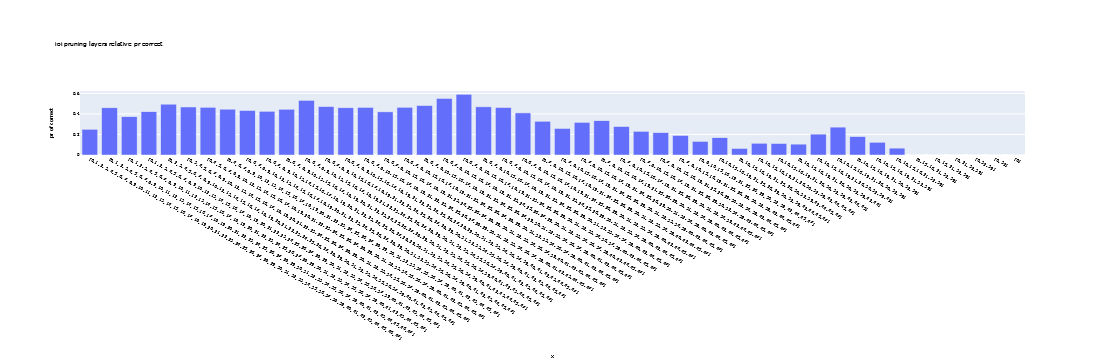

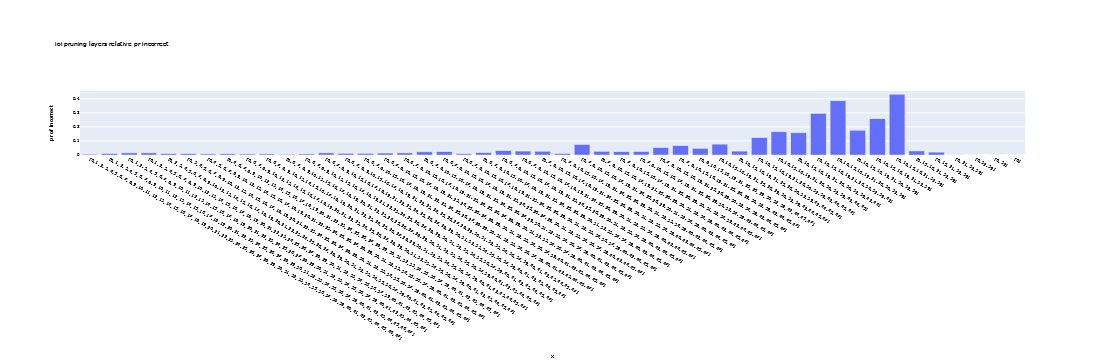

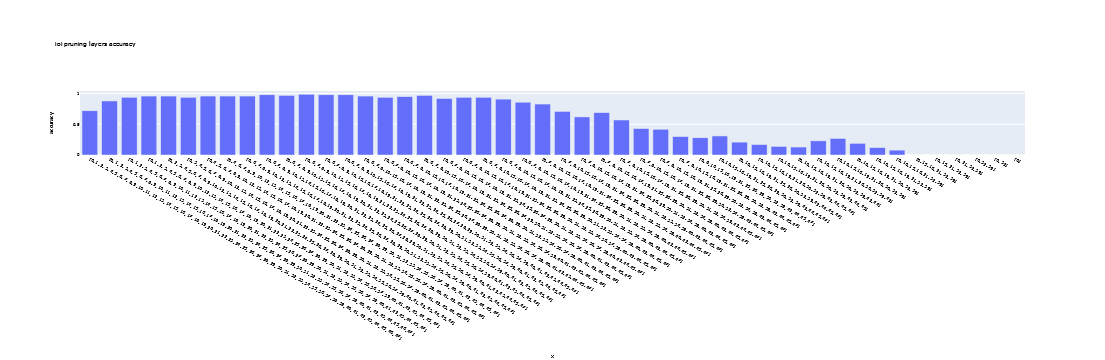

In [28]:
bar_chart(history_stats[:,0], x_labels=[str(x) for x in history], y_label=f'{relative_str}pr of correct', title=f"{data_type} pruning layers relative pr correct", font_size=4)
bar_chart(history_stats[:,1], x_labels=[str(x) for x in history], y_label=f'{relative_str}pr of incorrect', title=f"{data_type} pruning layers relative pr incorrect", font_size=4)
bar_chart(history_stats[:,2], x_labels=[str(x) for x in history], y_label='accuracy', title=f"{data_type} pruning layers accuracy", font_size=4)





